In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc,
    roc_curve
)
from sklearn.utils.class_weight import compute_class_weight

np.random.seed(42)
tf.random.set_seed(42)


In [2]:
df = pd.read_csv("creditcard.csv")
X = df.drop("Class", axis=1)
y = df["Class"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(df["Class"].value_counts())


Class
0    284315
1       492
Name: count, dtype: int64


In [3]:
classes = np.unique(y)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y
)
class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict


{0: 0.5008652375006595, 1: 289.4380081300813}

In [4]:
def build_dnn(input_dim):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation="relu",
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation="relu",
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(32, activation="relu",
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4)),

        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [5]:
def evaluate_model(model, X_test, y_test):
    y_prob = model.predict(X_test).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    roc_auc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))
    return roc_auc, pr_auc, y_prob


In [6]:
def plot_curves(y_test, y_prob, title):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {title}")
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve – {title}")
    plt.tight_layout()
    plt.show()


Epoch 1/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8912 - loss: 0.3152
Epoch 2/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9567 - loss: 0.2004
Epoch 3/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9632 - loss: 0.1614
Epoch 4/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9639 - loss: 0.1395
Epoch 5/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9571 - loss: 0.1488
Epoch 6/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9630 - loss: 0.1285
Epoch 7/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9632 - loss: 0.1272
Epoch 8/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9618 - loss: 0.1251
Epoch 9/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9663 - loss: 0.1085
Epoch 10/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9701 - loss: 0.1012
Epoch 11/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9686 - loss: 0.1185
Epoch 12/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

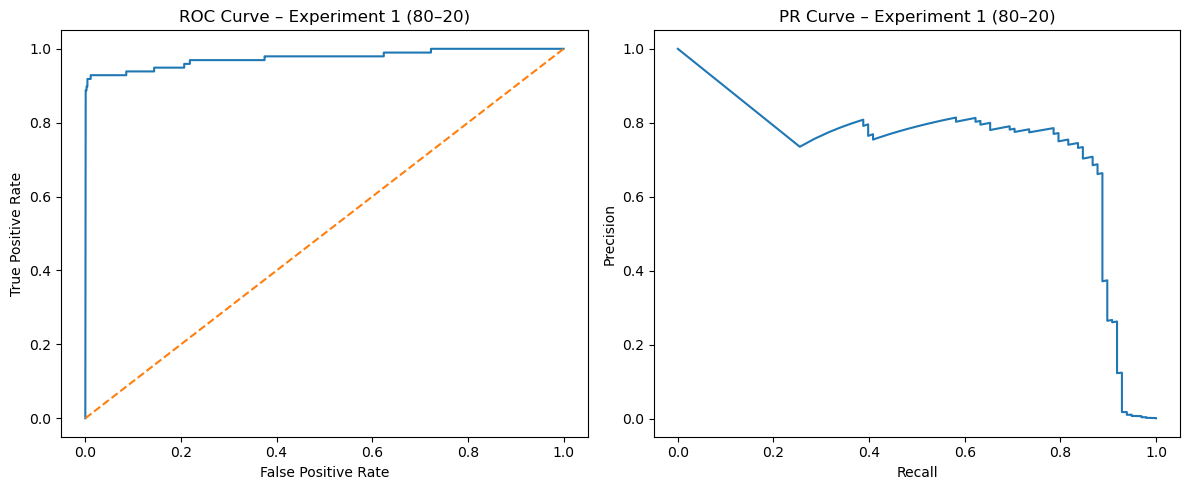

In [7]:
#Experiment 1 — 80–20 Train–Test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
model = build_dnn(X_train.shape[1])
model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=256,
    class_weight=class_weight_dict,
    verbose=1
)
roc1, pr1, y_prob1 = evaluate_model(model, X_test, y_test)
plot_curves(y_test, y_prob1, "Experiment 1 (80–20)")

Epoch 1/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9312 - loss: 0.2686
Epoch 2/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9673 - loss: 0.1792
Epoch 3/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9635 - loss: 0.1674
Epoch 4/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9695 - loss: 0.1334
Epoch 5/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9731 - loss: 0.1169
Epoch 6/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9714 - loss: 0.1089
Epoch 7/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9728 - loss: 0.1008
Epoch 8/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9661 - loss: 0.1278
Epoch 9/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9738 - loss: 0.1058
Epoch 10/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9756 - loss: 0.1240
Epoch 11/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9711 - loss: 0.1267
Epoch 12/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

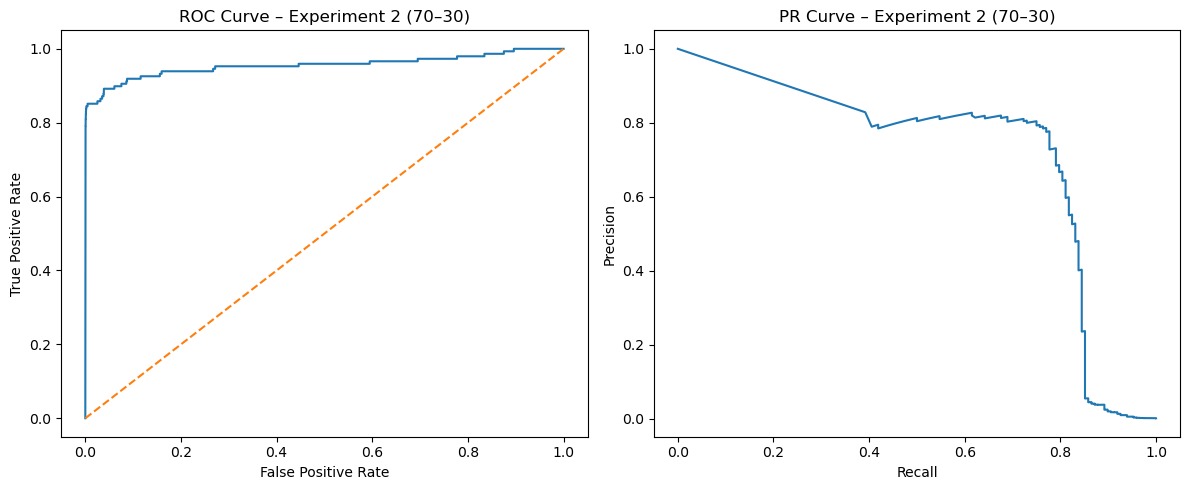

In [8]:
#Experiment 2 — 70–30 Train–Test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)
model = build_dnn(X_train.shape[1])
model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=256,
    class_weight=class_weight_dict,
    verbose=1
)
roc2, pr2, y_prob2 = evaluate_model(model, X_test, y_test)
plot_curves(y_test, y_prob2, "Experiment 2 (70–30)")

Epoch 1/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8984 - loss: 0.2786 - val_accuracy: 0.9735 - val_loss: 0.1275
Epoch 2/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9588 - loss: 0.1715 - val_accuracy: 0.9698 - val_loss: 0.1131
Epoch 3/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9562 - loss: 0.1558 - val_accuracy: 0.9710 - val_loss: 0.1095
Epoch 4/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9640 - loss: 0.1249 - val_accuracy: 0.9695 - val_loss: 0.1005
Epoch 5/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9669 - loss: 0.1022 - val_accuracy: 0.9811 - val_loss: 0.0707
Epoch 6/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9698 - loss: 0.1022 - val_accuracy: 0.9690 - val_loss: 0.0924
Epoch 7/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9661 - loss: 0.1085 - val_accuracy: 0.9732 - val_loss: 0.0829
Epoch 8/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9640 - loss: 0.1092 - val_accuracy: 0.

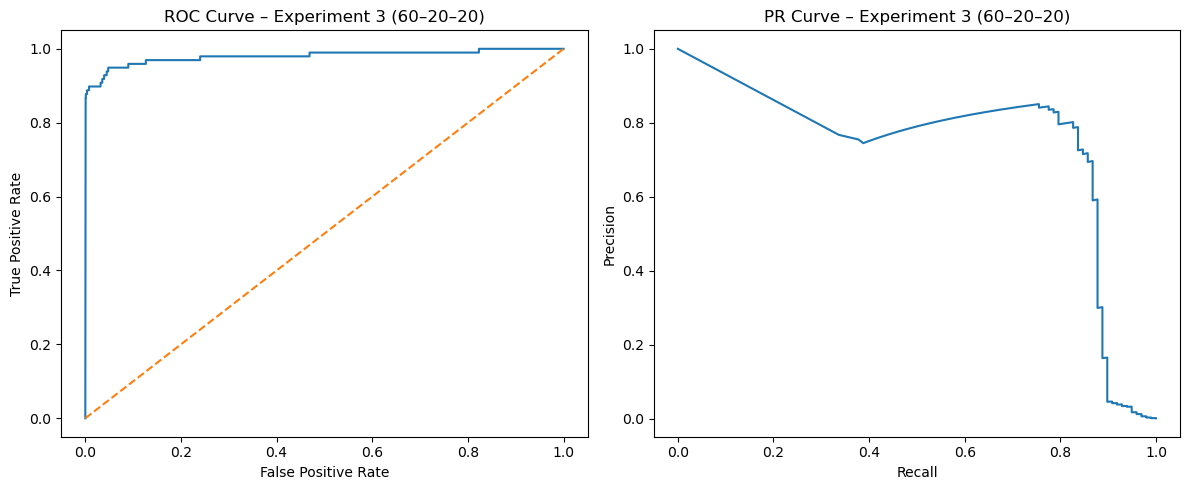

In [9]:
#Experiment 3 — 60–20–20 Train–Val–Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
model = build_dnn(X_train.shape[1])
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)
roc3, pr3, y_prob3 = evaluate_model(model, X_test, y_test)
plot_curves(y_test, y_prob3, "Experiment 3 (60–20–20)")

Epoch 1/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9200 - loss: 0.2954 - val_accuracy: 0.9723 - val_loss: 0.1485
Epoch 2/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9592 - loss: 0.1836 - val_accuracy: 0.9824 - val_loss: 0.1023
Epoch 3/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9595 - loss: 0.1644 - val_accuracy: 0.9788 - val_loss: 0.0975
Epoch 4/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9627 - loss: 0.1512 - val_accuracy: 0.9802 - val_loss: 0.0961
Epoch 5/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9635 - loss: 0.1313 - val_accuracy: 0.9823 - val_loss: 0.0803
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step
[[41407  1241]
 [    9    65]]
              precision    recall  f1-score   support

           0     0.9998    0.9709    0.9851     42648
           1     0.0498    0.8784    0.0942        74

    accuracy                         0.9707     42722
   macro avg     0.5248    0.9246    0.5397     42722
weighted avg

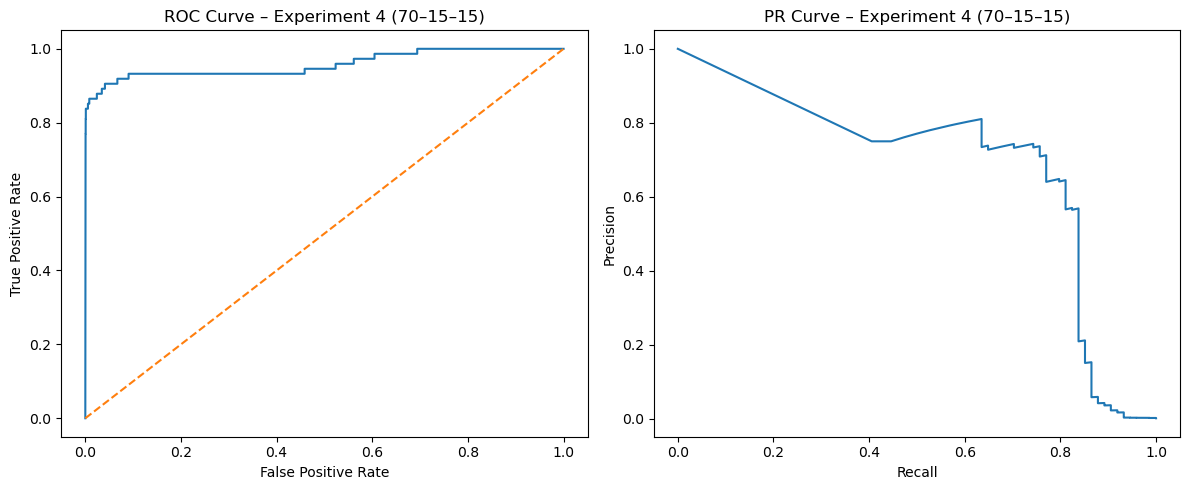

In [10]:
#Experiment 4 — 70–15–15 Train–Val–Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)
model = build_dnn(X_train.shape[1])
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)
roc4, pr4, y_prob4 = evaluate_model(model, X_test, y_test)
plot_curves(y_test, y_prob4, "Experiment 4 (70–15–15)")

In [11]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_scores = []
pr_scores = []
for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model = build_dnn(X_train.shape[1])
    model.fit(
        X_train, y_train,
        epochs=1,   # efficiency
        batch_size=256,
        class_weight=class_weight_dict,
        verbose=0
    )
    y_prob = model.predict(X_test).ravel()
    roc_scores.append(roc_auc_score(y_test, y_prob))
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_scores.append(auc(recall, precision))
print("ROC-AUC:", np.mean(roc_scores), "±", np.std(roc_scores))
print("PR-AUC:", np.mean(pr_scores), "±", np.std(pr_scores))


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step
ROC-AUC: 0.9784848432644765 ± 0.005738444144018976
PR-AUC: 0.7436861403226491 ± 0.029408610230991863


In [12]:
class_counts = df['Class'].value_counts()
print(class_counts)


Class
0    284315
1       492
Name: count, dtype: int64


In [13]:
# Percentage distribution
class_percentage = df['Class'].value_counts(normalize=True) * 100
print(class_percentage)


Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


In [14]:
# Imbalance ratio (majority / minority)
neg, pos = class_counts[0], class_counts[1]
imbalance_ratio = neg / pos

print("Imbalance Ratio (Normal : Fraud) =", imbalance_ratio)


Imbalance Ratio (Normal : Fraud) = 577.8760162601626


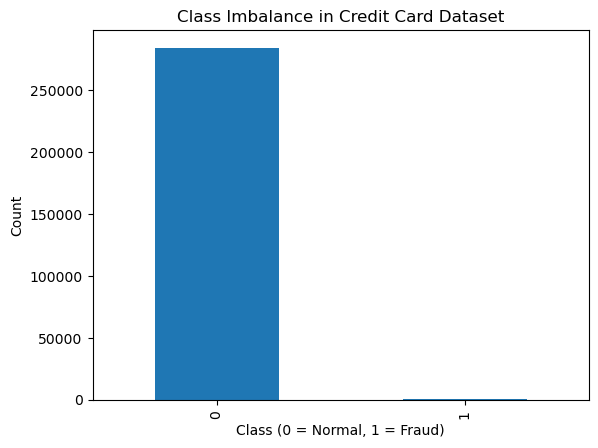

In [15]:
import matplotlib.pyplot as plt

plt.figure()
df['Class'].value_counts().plot(kind='bar')
plt.xlabel("Class (0 = Normal, 1 = Fraud)")
plt.ylabel("Count")
plt.title("Class Imbalance in Credit Card Dataset")
plt.show()


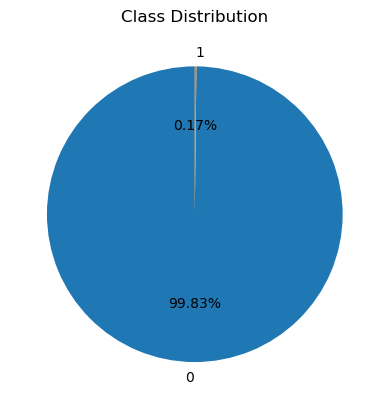

In [16]:
plt.figure()
df['Class'].value_counts().plot(
    kind='pie',
    autopct='%1.2f%%',
    startangle=90
)
plt.ylabel("")
plt.title("Class Distribution")
plt.show()


In [17]:
print(f"Normal transactions : {neg}")
print(f"Fraud transactions  : {pos}")
print(f"Fraud percentage    : {class_percentage[1]:.4f}%")


Normal transactions : 284315
Fraud transactions  : 492
Fraud percentage    : 0.1727%
